# 道路损害类型定义

表1: 我们数据集中的道路损害类型及其定义。

<table border="1">
  <thead>
    <tr>
      <th colspan="3">损害类型</th>
      <th>详细</th>
      <th>类型名称</th>
    </tr>
  </thead>

  <tbody>
    <tr>
      <td rowspan="5">裂缝</td>
      <td rowspan="4">线形裂缝</td>
      <td rowspan="2">纵向</td>
      <td>车辙部分</td>
      <td>D00</td>
    </tr>
    <tr>
      <td>施工接缝部分</td>
      <td>D01</td>
    </tr>
    <tr>
      <td rowspan="2">横向</td>
      <td>等距间隔</td>
      <td>D10</td>
    </tr>
    <tr>
      <td>施工接缝部分</td>
      <td>D11</td>
    </tr>
    <tr>
      <td colspan="2">鳄鱼裂缝</td>
      <td>部分铺装、整体铺装</td>
      <td>D20</td>
    </tr>
    <tr>
      <td colspan="3" rowspan="3">其他损坏</td>
      <td>车辙、颠簸、坑洼、分层</td>
      <td>D40</td>
    </tr>
    <tr>
      <td>十字路口模糊</td>
      <td>D43</td>
    </tr>
    <tr>
      <td>白线模糊</td>
      <td>D44</td>
    </tr>
  </tbody>
</table>

来源：2013年日本JRA（2013）的道路养护和修复指南书。    
*注意*：实际上，车辙、颠簸、坑洞和路面分离是不同类型的路面损坏，但使用图像很难区分这四种类型。因此，它们被归类为一个类别，即D40。

# 使用SSD_mobilenet进行道路损坏检测

# 导入

In [1]:
import numpy as np
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

if tf.__version__ != '1.4.1':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.1!')

/Users/xupengfei/anaconda3/envs/road/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/xupengfei/anaconda3/envs/road/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/xupengfei/anaconda3/envs/road/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/xupengfei/anaconda3/envs/road/lib

## 物体识别导入
以下是物体识别模块的导入

In [2]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# 模型准备
## 变量

只需更改`PATH_TO_CKPT`以指向新的 .pb 文件，即可在此处加载使用`export_inference_graph.py`工具导出的任何模型。

默认情况下，我们在这里使用“SSD with Mobilenet”模型，请参考[检测模型动物园](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md)，了解可以以不同速度和精度开箱即用运行的其他模型的列表。

In [3]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
# PATH_TO_CKPT =  'modal/trainedModels/ssd_mobilenet_innference_graph.pb' 
PATH_TO_CKPT =  'modal/trainedModels/ssd_inception_inference_graph.pb' 

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'crackLabelMap.txt'

NUM_CLASSES = 8

## 加载一个（冻结的）Tensorflow模型到内存中

In [4]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## 加载标签映射表

标签映射将索引映射到类别名称，因此当我们的卷积网络预测出 "5 "时，我们就知道这对应于 "飞机"。在这里，我们使用了内部实用程序函数，但任何能返回将整数映射到适当字符串标签的字典的函数都没问题

In [5]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## 帮助代码

In [6]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# 检测

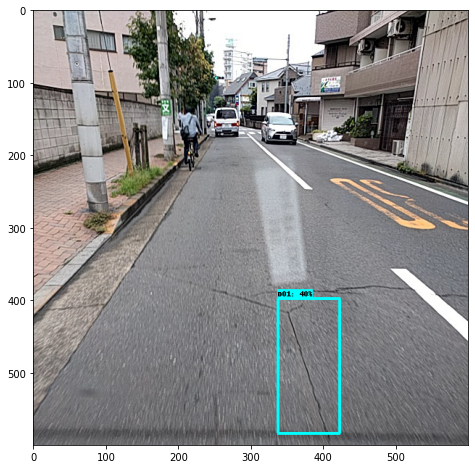

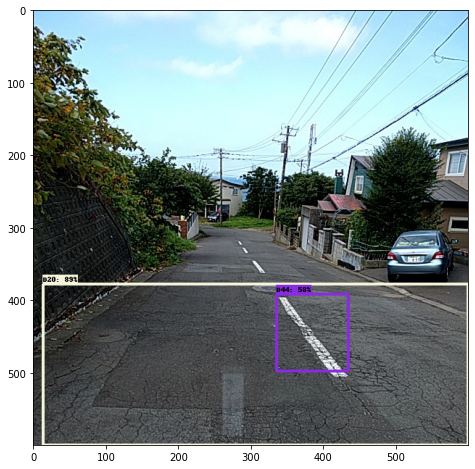

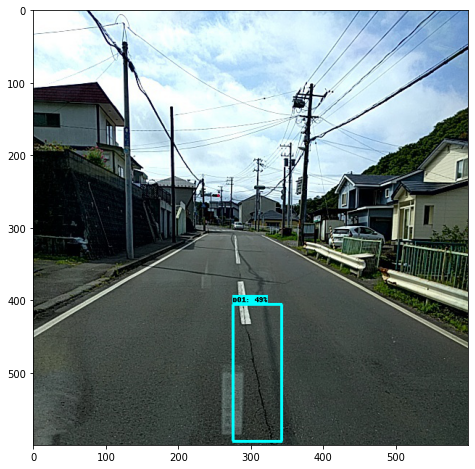

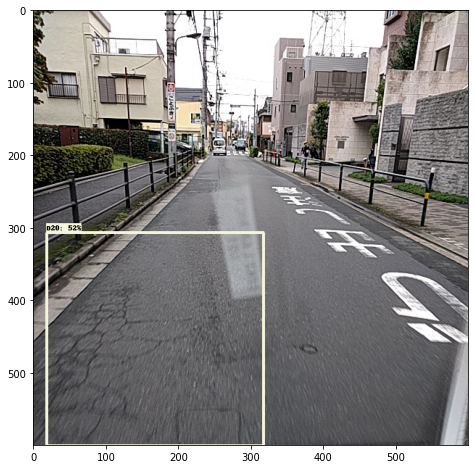

In [21]:
TEST_IMAGE_PATHS = [
  '/Users/xupengfei/workplace/learn/python/pytorch/RoadDamageDetector/data/test/1.jpg',
  '/Users/xupengfei/workplace/learn/python/pytorch/RoadDamageDetector/data/test/2.jpg',
  '/Users/xupengfei/workplace/learn/python/pytorch/RoadDamageDetector/data/test/3.jpg',
  '/Users/xupengfei/workplace/learn/python/pytorch/RoadDamageDetector/data/test/D20.jpg',
];
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open(image_path)
      # the array based representation of the image will be used later in order to prepare the
      # result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      # Actual detection.
      (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      # Visualization of the results of a detection.
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          min_score_thresh=0.3,
          use_normalized_coordinates=True,
          line_thickness=4)
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)